原圖(492x318)：


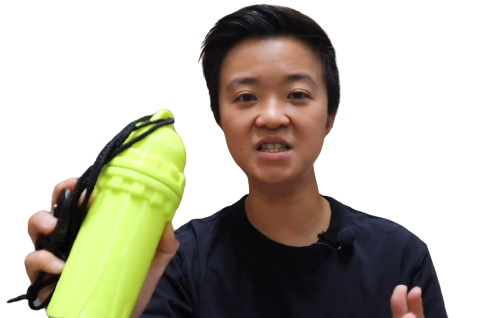

以高為基準縮放
縮放後179x116：


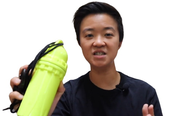

色彩量化：


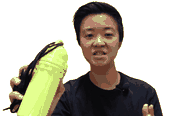

In [1]:
from PIL import Image
from IPython.display import display
import numpy as np
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from pynput.mouse import Button, Controller as MouseController
import time


# 可用顏色
colors = [
    (0, 0, 0),
    (102, 102, 102),
    (0, 23, 246),
    (255, 255, 255),
    (170, 170, 170),
    (38, 201, 255),
    (0, 141, 38),
    (169, 35, 12),
    (150, 65, 18),
    (0, 255, 77),
    (255, 0, 19),
    (255, 120, 41),
    (176, 112, 28),
    (153, 0, 78),
    (147, 104, 103),
    (255, 201, 38),
    (255, 0, 143),
    (254, 175, 168),
    # (0, 217, 163),
    # (133, 178, 0),
    # (128, 0, 255),
    # (5, 44, 108),
    # (185, 115, 255),
    # (255, 247, 63),
]


def color_diff(rgb1, rgb2):
    """計算CIE2000色差"""
    color1_rgb = sRGBColor(*rgb1, is_upscaled=True)
    color2_rgb = sRGBColor(*rgb2, is_upscaled=True)
    color1_lab = convert_color(color1_rgb, LabColor)
    color2_lab = convert_color(color2_rgb, LabColor)
    delta_e = delta_e_cie2000(color1_lab, color2_lab)
    return delta_e


def resize_based_on_width(im, basewidth=200):
    """以basewidth為基準，縮放圖片"""
    wpercent = basewidth / float(im.size[0])
    hsize = int((float(im.size[1]) * float(wpercent)))
    im = im.resize((basewidth, hsize), Image.Resampling.LANCZOS)
    return im


def resize_based_on_height(im, baseheight=116):
    """以baseheight為基準，縮放圖片"""
    hpercent = baseheight / float(im.size[1])
    wsize = int((float(im.size[0]) * float(hpercent)))
    im = im.resize((wsize, baseheight), Image.Resampling.LANCZOS)
    return im


def preprocess(im, basewidth=200, baseheight=116):
    """預處理圖片"""
    print(f"原圖({im.size[0]}x{im.size[1]})：")
    display(im)
    if im.size[0] / im.size[1] > 815 / 475:
        print('以寬為基準縮放')
        im = resize_based_on_width(im, basewidth)
    else:
        print('以高為基準縮放')
        im = resize_based_on_height(im, baseheight)
    print(f"縮放後{im.size[0]}x{im.size[1]}：")
    display(im)
    # im = im.filter(ImageFilter.GaussianBlur(0.7))
    # print('模糊後')
    # display(im)
    print("色彩量化：")
    im = im.quantize(24)
    display(im)
    im = im.convert("RGB")
    a = np.asarray(im)
    return a, im.size


color_id_map = {}


def make_line(a):
    """1 image row to line"""
    line = []
    head = None
    for i in range(len(a) - 1):
        if i == 0:
            head = i
        else:
            if (a[i] != a[i + 1]).all():
                tail = i

                min_color_id = None
                if tuple(a[i]) not in color_id_map:
                    for j in range(len(colors)):
                        delta = color_diff(a[i], colors[j])
                        if min_color_id is None:
                            min_color_id = j
                            min_delta = delta
                        else:
                            if delta < min_delta:
                                min_color_id = j
                                min_delta = delta
                    color_id_map[tuple(a[i])] = min_color_id
                else:
                    min_color_id = color_id_map[tuple(a[i])]

                if min_color_id != 3:  # white
                    line += [[head, tail, min_color_id]]
                # next
                head = i + 1
    return line


def make_lines(a):
    """image to lines"""
    lines = []
    for a_ in a:
        lines += [make_line(a_)]
    return lines


def draw_by_color(driver, lines, xoffset=10, yoffset=10, gap=1, line_height=None):
    color_elem_map = {}
    for i in range(len(colors)):
        color_elem_map[i] = driver.find_element(
            By.XPATH,
            f"/html/body/div[2]/div/div[2]/div[1]/div/div/div[1]/div[2]/div/div[2]/div[1]/div[{i+1}]",
        )
    if line_height is None:
        line_height = gap

    color_map = {}
    for height, line in enumerate(lines):
        for seg in line:
            seg += [height]
            if seg[2] not in color_map:
                color_map[seg[2]] = [seg]
            else:
                color_map[seg[2]] += [seg]

    mouse = MouseController()
    for color, color_line in color_map.items():
        color_elem_map[color].click()
        for i, seg in enumerate(color_line):
            mouse.position = (xoffset + seg[0] * gap, yoffset + seg[3] * line_height)

            time.sleep(0.00001)
            if seg[0] == seg[1]:
                mouse.click(Button.left)
            else:
                mouse.press(Button.left)
                # time.sleep(0.005)
                mouse.move((seg[1] - seg[0]) * gap, 0)
                time.sleep(0.0001)
                mouse.release(Button.left)


im = Image.open("image.jpg")
preprocess(im)
print()


In [2]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

options = Options()
options.add_extension("uBlock-Origin.crx")
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
driver.get("https://gartic.io/")

print("Chrome Browser Invoked")


[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - About to download new driver from https://chromedriver.storage.googleapis.com/102.0.5005.61/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\Asus\.wdm\drivers\chromedriver\win32\102.0.5005.61]
C:\Users\Asus\AppData\Local\Temp\ipykernel_9400\611495026.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)


Chrome Browser Invoked


In [9]:
# 找出題目
driver.switch_to.window(driver.window_handles[0])
soup = BeautifulSoup(driver.page_source, "html.parser")
titles = soup.find_all("div", class_="word")
if titles:
    keyword = titles[0].text
    for i in range(1, len(titles)):
        keyword += " " + titles[i].text
    print("題目：" + keyword)

# keyword = ""
suffix = ""
if suffix != "":
    query = keyword + "+" + suffix
else:
    query = keyword
script = (
    f"window.open('https://www.google.com/search?q={query}&tbm=isch&hl=zh-TW');"
)
driver.execute_script(script)

題目：獵人


儲存圖片(image.jpg)：


d:\workspace\py\garticio_selenium\venv\lib\site-packages\selenium\webdriver\remote\webelement.py:723: UserWarning: name used for saved screenshot does not match file type. It should end with a `.png` extension
  warnings.warn("name used for saved screenshot does not match file "


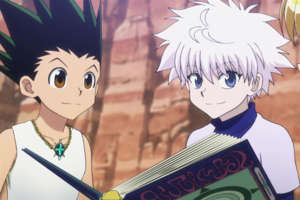

In [10]:
# 儲存圖片
driver.switch_to.window(driver.window_handles[1])
driver.execute_script('function getElementByXpath(a){return document.evaluate(a,document,null,XPathResult.FIRST_ORDERED_NODE_TYPE,null).singleNodeValue}let elem=getElementByXpath("/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div[1]");elem.parentNode.removeChild(elem),(elem=getElementByXpath("/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div/div/div[2]/a")).parentNode.removeChild(elem)')
img = driver.find_element(By.XPATH, '/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div/div/a/img')
img.screenshot('image.jpg')
print('儲存圖片(image.jpg)：')
display(Image.open('image.jpg'))

原圖(300x200)：


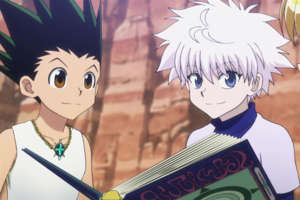

以高為基準縮放
縮放後174x116：


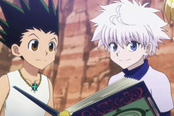

色彩量化：


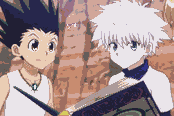

ElementClickInterceptedException: Message: element click intercepted: Element <div class="color" style="background-color: rgb(254, 175, 168);"></div> is not clickable at point (682, 569). Other element would receive the click: <span class="nick">...</span>
  (Session info: chrome=102.0.5005.115)
Stacktrace:
Backtrace:
	Ordinal0 [0x005FD953+2414931]
	Ordinal0 [0x0058F5E1+1963489]
	Ordinal0 [0x0047C6B8+837304]
	Ordinal0 [0x004AFC27+1047591]
	Ordinal0 [0x004ADC08+1039368]
	Ordinal0 [0x004AB90B+1030411]
	Ordinal0 [0x004AA659+1025625]
	Ordinal0 [0x004A0293+983699]
	Ordinal0 [0x004C449C+1131676]
	Ordinal0 [0x0049FC74+982132]
	Ordinal0 [0x004C46B4+1132212]
	Ordinal0 [0x004D4812+1198098]
	Ordinal0 [0x004C42B6+1131190]
	Ordinal0 [0x0049E860+976992]
	Ordinal0 [0x0049F756+980822]
	GetHandleVerifier [0x0086CC62+2510274]
	GetHandleVerifier [0x0085F760+2455744]
	GetHandleVerifier [0x0068EABA+551962]
	GetHandleVerifier [0x0068D916+547446]
	Ordinal0 [0x00595F3B+1990459]
	Ordinal0 [0x0059A898+2009240]
	Ordinal0 [0x0059A985+2009477]
	Ordinal0 [0x005A3AD1+2046673]
	BaseThreadInitThunk [0x764E6739+25]
	RtlGetFullPathName_UEx [0x77C08FEF+1215]
	RtlGetFullPathName_UEx [0x77C08FBD+1165]


In [11]:
# 畫畫
if len(driver.window_handles) > 1:
    driver.close()
driver.switch_to.window(driver.window_handles[0])

wait = WebDriverWait(driver, 999999, 0.5)
element = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "hint")))
wait = WebDriverWait(driver, 999999, 0.5)
elem = wait.until(EC.element_to_be_clickable((By.TAG_NAME, "canvas")))

with Image.open("image.jpg") as im:
    if elem:
        w, h = (200, 116)
        a, size = preprocess(im, w, h)
        lines = make_lines(a)
        time.sleep(3)
        xoffset = (w - size[0]) / 2 * 800 / w
        draw_by_color(
            driver=driver,
            lines=lines,
            gap=2.5,
            xoffset=750 + xoffset,
            yoffset=270,
        )
